# Forrest Plot to compare reproduction of previous results

In [1]:
%load_ext autoreload
%autoreload 2
from analysis_settings import *
from plot_settings import *
from scripts.utils_plot import _save_fig, _corr_results, _get_cohen_stats
import numpy as np
import pingouin as pg
import math
from scipy.stats import bootstrap
from scripts.utils_plot import cohen_d, equalize_x_and_y
from scripts.utils import _average_hemispheres

In [2]:
print(f'Estimated sample size for correlation Lofredi 2023: {pg.power_corr(r=0.208, power=0.8):.0f}')

Estimated sample size for correlation Lofredi 2023: 178


# Is low beta significantly reduced by LDOPA?

In [3]:
ch_choice = 'ch_dist_sweet'
dataframes = get_dfs(ch_choice)
n_perm = 10000
# n_perm = None

/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['sub_hemi_cond'] = df.sub_hemi + '_' + df.cond
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pivot['UPDRS_exists'] = pivot.UPDRS_bradyrigid_contra.notna()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:82: 

# Plot correlations

- signficane based on permutation testing, confidence intervals based on bootstrapping

In [4]:
def forest_plot_correlation(df, X, y, n_perm=10000, r_lim=None, suffix='',
                            ylabels=True, add_sample_sizes=False,
                            significance_based_on_ci=True,
                            band_titles=True, fig_dir=None, orientation='h'):

    projects = cfg.PROJECT_NAMES
    n_projects = len(projects)
    cond = df.cond.unique()[0]

    # Plot
    # fig, axes = plt.subplots(1, len(X), figsize=(6.63, 1.2), sharey=True)
    n_plots = len(X)
    rows = 1
    cols = n_plots
    height = 1.2 if band_titles else 1.06
    width = 1 * n_plots
    if orientation == 'h':
        project_order = list(reversed(projects))
        # Create custom y-tick positions
        # Squeeze the first n-1 projects
        squeezed_y_positions = np.linspace(0.3, 1, n_projects - 1)
        last_y_position = 0  # Place the last project further down
        positions = np.concatenate(([last_y_position], squeezed_y_positions))
    elif orientation == 'v':
        rows, cols = cols, rows
        height, width = width, height
        project_order = list(projects)

        positions = np.linspace(0, 1, n_projects)
    fig, axes = plt.subplots(rows, cols, figsize=(width, height), sharey=True,
                             sharex=True)
    axes = np.array([axes]) if n_plots == 1 else axes

    # n_significant_projects = 0
    labels = []
    colors = []
    for j, x in enumerate(X):
        ax = axes[j]
        for i, project in enumerate(project_order):
            # Calc correlation
            df_proj = df[df.project_nme == project]
            if 'contra' not in y:
                df_proj = _average_hemispheres(df_proj, x, y)
            corr_results = _corr_results(df_proj, x, y, 'spearman',
                                         n_perm=n_perm, pval_string=False)
            rho, sample_size, pval, _, ci = corr_results
            if j == 0:
                if add_sample_sizes:
                    label = project + f' (n={sample_size})'
                else:
                    label = project
                    if project == 'all':
                        print(f'Sample size for {y} {cond} (all): {sample_size}')
                labels.append(label)

            mean_val = rho
            ci_lower, ci_upper = ci
            error = [[mean_val - ci_lower], [ci_upper - mean_val]]
            markersize = sample_size / 20
            color = cfg.COLOR_DIC[project]
            colors.append(color)

            # Issue: CI ovlerapping with zero (insignificant) and
            # p-value < 0.05 (significant) is no contradiction since
            # statistical tests not equivalent. Can lead to minor
            # discrepancies. Solution: Use CI to indicate significance as
            # triangle/square marker since more intuitive and very similar
            # to p-value anyways.
            if significance_based_on_ci:
                # Test significance using bootstrap CI
                corr_positive = ci[0] > 0 and ci[1] > 0
                corr_negative = ci[0] < 0 and ci[1] < 0
                non_significant = ci[0] <= 0 <= ci[1]
                if corr_positive or corr_negative:
                    if corr_positive:
                        marker = '>'
                    elif corr_negative:
                        marker = '<'
                else:
                    marker = 's'
                    assert non_significant or np.isnan(rho)
            else:
                # Test significance using permutation test pvalue
                if pval < 0.05:
                    if rho > 0:
                        marker = '>'
                    elif rho < 0:
                        marker = '<'
                else:
                    marker = 's'

            if project == 'all':
                rho_all = rho
                ci_all = ci
                pval_all = pval

            # Plot markers
            if orientation == 'h':
                error_kwargs = dict(xerr=error)
            elif orientation == 'v':
                error_kwargs = dict(yerr=error)
                marker = marker.replace('>', '^').replace('<', 'v')
            x_plot = mean_val
            y_plot = positions[i]
            if orientation == 'v':
                x_plot, y_plot = y_plot, x_plot
            ax.plot(x_plot, y_plot, marker, color=color,
                    markersize=markersize)
            # Plot confidence intervals (bootstrap)
            ax.errorbar(x_plot, y_plot, **error_kwargs, color='grey',
                        markersize=0, capsize=0)

        # Power analysis
        required_n = pg.power_corr(r=rho_all, power=0.8)
        # required_n_sub = pg.power_corr(r=rho_all_sub, power=0.8)
        if ci_all[0] < 0 < ci_all[1]:
            # required_n = 'n.s.'
            required_n = ''
            # labelpad important to enable equal height with UPDRS-III if no
            # required n
            labelpad = 12.5
            # required_n_hemi = 'n/a'
        else:
            if 'contra' not in y:
                required_n = f'\nRequired {cfg.SAMPLE_PAT}={math.ceil(required_n)}'
            else:
                required_n = f'\nRequired  {cfg.SAMPLE_STN}={math.ceil(required_n)}'
            labelpad = None
            # required_n_hemi = math.ceil(required_n_hemi)
        # if ci_all_sub[0] < 0 < ci_all_sub[1]:
        #     # required_n_sub = ''
        #     required_n_sub = 'n/a'
        # else:
        #     # required_n_sub = r'($n_{\mathrm{min}}$='f'{math.ceil(required_n_sub)})'
        #     required_n_sub = math.ceil(required_n_sub)
        # required_n = r'($n_{\mathrm{sub}}$='f'{required_n_sub}, 'r'$n_{\mathrm{hemi}}$='f'{required_n_hemi})'

        # Set axis
        if band_titles:
            band_title = cfg.PLOT_LABELS[x].replace(' Peak', '').replace(' mean', '')
        else:
            band_title = ''
        rho_string = r'$\rho_{\mathrm{all}}=$'f'{rho_all:.2f}'
        pval_string = f"(p={pval_all:1.0e})" if abs(pval_all) < 0.005 else f"(p={pval_all:.2f})"
        fontweight = 'bold' if pval_all < 0.05 else 'normal'
        stat_string = rho_string + ' ' + pval_string + required_n
        if orientation == 'h':
            ax.axvline(0, color="k", linestyle="-", lw=LINEWIDTH_AXES)
            if j > 0:
                ax.yaxis.set_tick_params(width=0, length=0)
            ax.spines['left'].set_visible(False)
            if ylabels:
                ticks = positions
                ax.set_yticks(ticks=ticks, labels=labels)
                for lab, color in zip(ax.get_yticklabels(), colors):
                    lab.set_color(color)
            else:
                ax.set_yticks([])
            ax.set_xlabel(stat_string, fontweight=fontweight, ha='left', x=0,
                          labelpad=labelpad)
            # title = f'{band_title}\n{required_n}'
            title = band_title
            ax.set_title(title, linespacing=1.3, y=.9)
            ax.set_xlim(r_lim)
        # elif orientation == 'v':
        #     ax.axhline(0, color="k", linestyle="-", lw=LINEWIDTH_AXES)
        #     ax.set_xticks([])
        #     ax.set_ylabel(None)
        #     ax.set_xlabel(None)
        #     ax.spines['bottom'].set_visible(False)
        #     ax.set_ylabel(r'$\rho$')
        #     # pval_string = r'$p_{\mathrm{all}}=$'f'{pval_all:.2f}'
        #     title = f'{band_title}\n{stat_string}\n{required_n}'
        #     # title += f'\n{rho_string}, 'r'$p_{\mathrm{all}}=$'f'{pval_all:.2f}'
        #     ax.set_title(title)
        #     ax.set_ylim(r_lim)

        # ax.yaxis.set_tick_params(width=0)
        # title = (f'{cfg.PLOT_LABELS[x].replace(' Peak', '')}\n' + required_n)
        # title = (f'{cfg.PLOT_LABELS[x].replace(' Peak', '')}\n' + required_n)
        if orientation == 'h':
            ymin, ymax = ax.get_ylim()
            yscale = ymax - ymin
            ax.set_ylim(-yscale*.2, ymax*1.01)
        elif orientation == 'v':
            xmin, xmax = ax.get_xlim()
            xscale = xmax - xmin
            ax.set_xlim(-xscale*.1, xmax*1.03)
        # ax.set_ylim(y_positions[0] - 0.3, y_positions[-1] + .1)
    plt.tight_layout()
    # band_str = '_'.join(X).replace('_abs_max_log', '').replace('_fm_powers_max_log', '')
    # band_str = ''  # file name too long
    if df.psd_kind.unique()[0] == 'normalized':
        kind = 'normalized'
    elif 'fm' in x:
        kind = 'periodic'
    else:
        kind = 'absolute'
    figname = f'PSDs_forrest_plot_correlation_{cond}_{kind}_{y}_{orientation}_nperm={n_perm}{suffix}'
    if fig_dir is None:
        fig_dir = KIND_DIR[kind]
    _save_fig(fig, join(fig_dir, ch_choice, figname),
              SAVE_DIR, close=False, transparent=True, bbox_inches=None)

In [5]:
# bands = ['alpha_beta_abs_max_log', 'beta_abs_max_log', 'beta_low_abs_max_log']
bands = ['alpha_beta_abs_mean_log', 'beta_abs_mean_log', 'beta_low_abs_mean_log']

# Normalized

Sample size for UPDRS_bradyrigid_contra off (all): 216
Sample size for UPDRS_III off (all): 119
Sample size for UPDRS_bradyrigid_contra offon_abs (all): 177
Sample size for UPDRS_III offon_abs (all): 99
Sample size for UPDRS_bradyrigid_contra on (all): 190
Sample size for UPDRS_III on (all): 105


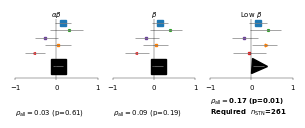

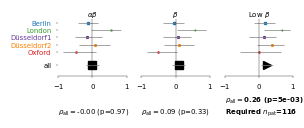

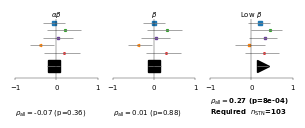

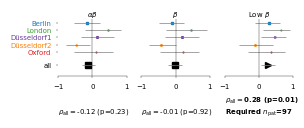

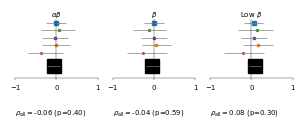

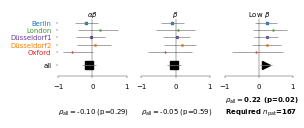

In [6]:
df_plot = dataframes['df_norm']
for cond in ['off', 'offon_abs', 'on']:
# for cond in ['off']:
    df_cond = df_plot[df_plot.cond == cond]
    forest_plot_correlation(df_cond, bands, 'UPDRS_bradyrigid_contra', orientation='h',
                            suffix='_ppp', add_sample_sizes=False,
                            n_perm=n_perm,
                            ylabels=False,
                            r_lim=(-1, 1))
    forest_plot_correlation(df_cond, bands, 'UPDRS_III', orientation='h',
                            suffix='_ppp',
                            n_perm=n_perm,
                            add_sample_sizes=False,
                            ylabels=True,
                            r_lim=(-1, 1))

In [ ]:
1/0

# Absolute

Sample size for UPDRS_bradyrigid_contra off (all): 216
Sample size for UPDRS_III off (all): 119
Sample size for UPDRS_bradyrigid_contra offon_abs (all): 177
Sample size for UPDRS_III offon_abs (all): 99


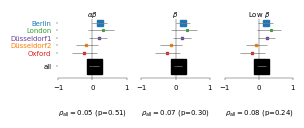

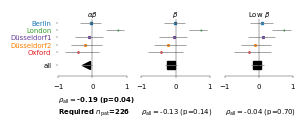

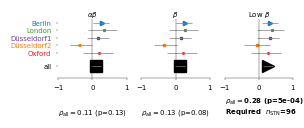

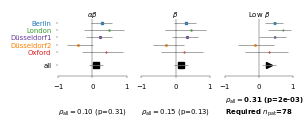

In [7]:
df_plot = dataframes['df_abs']

for cond in ['off', 'offon_abs']:
    df_cond = df_plot[df_plot.cond == cond]

    forest_plot_correlation(df_cond, bands, 'UPDRS_bradyrigid_contra', orientation='h',
                            suffix='_theta',
                            n_perm=n_perm,
                            r_lim=(-1, 1))
    forest_plot_correlation(df_cond, bands, 'UPDRS_III', orientation='h',
                            suffix='_theta',
                            n_perm=n_perm,
                            r_lim=(-1, 1))

# Periodic

Sample size for UPDRS_bradyrigid_contra off (all): 208
Sample size for UPDRS_III off (all): 115
Sample size for UPDRS_bradyrigid_contra offon_abs (all): 164
Sample size for UPDRS_III offon_abs (all): 94


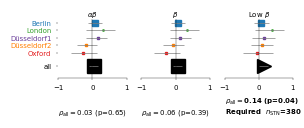

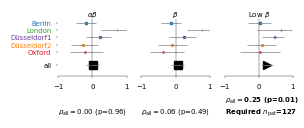

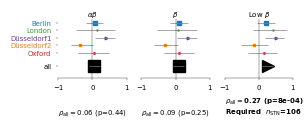

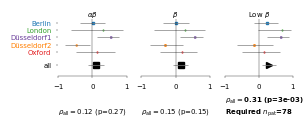

In [8]:
# X_per = ['alpha_beta_fm_powers_max_log', 'beta_fm_powers_max_log', 'beta_low_fm_powers_max_log']
X_per = ['alpha_beta_fm_mean_log', 'beta_fm_mean_log', 'beta_low_fm_mean_log']

df_plot = dataframes['df_per']
for cond in ['off', 'offon_abs']:
    df_cond = df_plot[df_plot.cond == cond]

    forest_plot_correlation(df_cond, X_per, 'UPDRS_bradyrigid_contra', orientation='h',
                            n_perm=n_perm,
                            r_lim=(-1, 1))
    forest_plot_correlation(df_cond, X_per, 'UPDRS_III', orientation='h',
                            n_perm=n_perm,
                            r_lim=(-1, 1))

In [9]:
1/0

ZeroDivisionError: division by zero

In [ ]:
# def forest_plot_corr_by_proj(df, X, y, n_perm=100):

#     x_buffer = .3
#     x_space = 1
#     # x_positions = [x_buffer, x_buffer*3, x_buffer*5, 2.25, 3.25]
#     x_positions = np.array([x_space*0, x_space*1*.75, x_space*2*.75, x_space*3*.9, x_space*4, x_space*5])
#     x_positions = x_positions + x_buffer

#     # Plot
#     fig, axes = plt.subplots(1, len(cfg.PROJECT_NAMES), figsize=(7, 1),
#                              sharey=True)

#     n_significant_projects = 0
#     for j, project in enumerate(cfg.PROJECT_NAMES):
#         df_proj = df[df.project_nme == project]
#         ax = axes[j]

#         for i, x in enumerate(X):
#             # Calc correlation
#             corr_results = _corr_results(df_proj, x, y, 'spearman',
#                                          n_perm=n_perm)
#             rho, sample_size, label, weight, ci = corr_results

#             mean_val = rho
#             ci_lower, ci_upper = ci
#             error = [[mean_val - ci_lower], [ci_upper - mean_val]]
#             color = cfg.COLOR_DIC[project]

#             # Count number of significant projects
#             corr_positive = ci[0] > 0 and ci[1] > 0
#             corr_negative = ci[0] < 0 and ci[1] < 0
#             non_significant = ci[0] < 0 < ci[1]
#             if corr_positive or corr_negative:
#                 if project != 'all':
#                     n_significant_projects += 1
#                 if corr_positive:
#                     marker = '^'
#                 elif corr_negative:
#                     marker = 'v'
#             else:
#                 marker = 's'
#                 assert non_significant

#             if project == 'all':
#                 rho_all = rho
#                 ci_all = ci
#                 markersize = 3
#             else:
#                 markersize = sample_size / 10

#             # Plot markers
#             ax.plot(x_positions[i], mean_val, marker,
#                     # color=color,
#                     # color='k',
#                     color='grey',
#                     markersize=markersize)
#             ax.errorbar(x_positions[i], mean_val, yerr=error,
#                         # color='k',
#                         color=color,
#                         lw=1,
#                         markersize=0, capsize=0)

#         xlabels = [cfg.PLOT_LABELS[x].replace(' Peak', '') for x in X]
#         ax.set_xticks(ticks=x_positions, labels=xlabels)
#         ax.set_xlim(0, x_positions[-1] + x_buffer)
#         ax.axhline(0, color="k", linestyle="-")
#         if j > 0:
#             # ax.set_yticks([])
#             ax.yaxis.set_tick_params(width=0, length=0)
#             ax.set_ylabel(None)
#             ax.spines['left'].set_visible(False)
#         else:
#             ax.set_ylabel(r'Spearman $\rho$')
#         ax.spines['bottom'].set_visible(False)

#     # Power analysis
#     required_n = pg.power_corr(r=rho_all, power=0.8)
#     if ci_all[0] < 0 < ci_all[1]:
#         required_n = 'N/A'
#     else:
#         required_n = f'{math.ceil(required_n)}'

#     # # Set axis
#     # title = (f'{cfg.PLOT_LABELS[x]} ~ AR\n'
#     #          f'Signficant projects: {n_significant_projects}/5\n'
#     #          f'Required hemispheres: {required_n}')
#     # ax.set_title(title)

#     plt.tight_layout()
#     # plt.subplots_adjust(hspace=0.05, wspace=0.05)
#     _save_fig(fig, f'Figure1/{ch_choice}/PSDs_forrest_plot_corr_norm_all_',
#               SAVE_DIR, close=False, transparent=True, bbox_inches=None)

In [ ]:
# forest_plot_corr_by_proj(df_norm, X, y=y, n_perm=None)

# Band powers

In [ ]:
def forest_plot_effect_size(df, x, estimator='effect_size', n_boot=10000):

    df = df.dropna(subset=[x])

    project_order = reversed(cfg.PROJECT_NAMES)

    n_significant_projects = 0

    # Plot
    fig, ax = plt.subplots(figsize=(2, 2))

    for project in project_order:
        df_proj = df[df.project_nme == project]
        if estimator == 'effect_size':
            assert df_proj.cond.nunique() == 2, 'Effect size requires two conds'
            df_proj, n = equalize_x_and_y(df_proj, 'cond', x)
            off_arr = df_proj[df_proj.cond == 'off'][x].values
            on_arr = df_proj[df_proj.cond == 'on'][x].values
            value = cohen_d(off_arr, on_arr)
            # value, n_cohen = _get_cohen_stats(df_proj, 'cond', x)
            # n1, n2 = n_cohen
            # parametric (fast but more assumptions)
            # ci = pg.compute_esci(value, n1, n2, paired=True)

            # nonparametric (slow but more correct)
            data = (off_arr, on_arr)
            ci = bootstrap(data, cohen_d, paired=True, n_resamples=n_boot)
            ci = ci.confidence_interval
            markersize = n / 10
        elif estimator == 'mean':
            value = df_proj[x].mean()
            n = len(df_proj[x])
            markersize = n / 10
            ci = bootstrap_ci(df_proj[x], estimator=estimator,
                              num_bootstrap=n_boot)
        elif estimator == 'median':
            value = df_proj[x].median()
            n = len(df_proj[x])
            markersize = n / 10
            ci = bootstrap_ci(df_proj[x], estimator=estimator,
                              num_bootstrap=n_boot)

        ci_lower, ci_upper = ci
        error = [[value - ci_lower], [ci_upper - value]]
        color = cfg.COLOR_DIC[project]
        # if project == 'all':
            # color = 'grey'

        # Plot markers
        ax.plot(value, project, 's', color=color, markersize=markersize)
        ax.errorbar(value, project, xerr=error,
                    # color='k',
                    color='grey', lw=1,
                    markersize=0, capsize=0)

        # Count number of significant projects
        if not ci_lower < 0 < ci_upper and project != 'all':
            n_significant_projects += 1

        if project == 'all':
            mean_val_all = value
            ci_all = ci
    ax.axvline(0, color="k", linestyle="-")

    if estimator == 'effect_size':
        # Calculate the required sample size using pingouin
        required_n = pg.power_ttest(d=mean_val_all, power=0.8)
        if ci_all[0] < 0 < ci_all[1]:
            required_n = 'N/A'
        else:
            required_n = f'{math.ceil(required_n)}'
    else:
        required_n = 'N/A'

    # Set axis
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_tick_params(width=0)
    title = f'Significant projects: {n_significant_projects}/5\nRequired hemispheres: {required_n}'
    ax.set_title(title, fontsize=8)
    # ax.set_xlabel('Low Beta Peak Off-On')
    ax.set_xlabel(cfg.PLOT_LABELS[x])
    ax.margins(y=0.2)  # Adds a 20% margin to the y-axis limits for very larger marker sizes
    plt.tight_layout()
    plt.show()


def bootstrap_ci(data, estimator='median', num_bootstrap=10000, ci_level=95):
    func = np.median if estimator == 'median' else np.mean
    # # Bootstrap resampling
    # boot_means = []
    # for _ in range(num_bootstrap):
    #     resample = np.random.choice(data, size=len(data), replace=True)
    #     boot_means.append(func(resample))

    # # Calculate the confidence interval
    # lower_bound = np.percentile(boot_means, (100 - ci) / 2)
    # upper_bound = np.percentile(boot_means, 100 - (100 - ci) / 2)

    # Scipy implementation is faster and bias corrected
    ci = bootstrap((data.values,), func, confidence_level=ci_level/100,
                   n_resamples=num_bootstrap,
                   method='bca',
                #    method='percentile',
                   paired=True)
    lower_bound, upper_bound = ci.confidence_interval
    assert func(data) >= lower_bound and func(data) <= upper_bound
    return lower_bound, upper_bound

In [ ]:
forest_plot_effect_size(df_norm, 'beta_low_abs_max_log', estimator='median')

NameError: name 'df_norm' is not defined

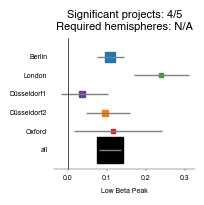

In [ ]:
forest_plot_effect_size(df_norm, 'beta_low_abs_max_log', estimator='mean')

/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_plot.py:696: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.set_index(group)[hemi_both_conds].reset_index()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_plot.py:696: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.set_index(group)[hemi_both_conds].reset_index()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_plot.py:696: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.set_index(group)[hemi_both_conds].reset_index()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_plot.py:696: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.set_index(group)[hemi_both_conds].reset_index()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_pl

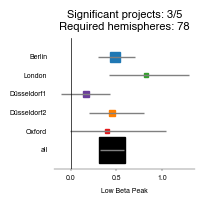

In [ ]:
df_norm = dataframes['df_norm']
df_norm_conds = df_norm[df_norm.cond.isin(['off', 'on'])]
forest_plot_effect_size(df_norm_conds, f'beta_low_abs_max_log', estimator='effect_size')

/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_plot.py:696: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.set_index(group)[hemi_both_conds].reset_index()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_plot.py:696: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.set_index(group)[hemi_both_conds].reset_index()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_plot.py:696: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.set_index(group)[hemi_both_conds].reset_index()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_plot.py:696: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.set_index(group)[hemi_both_conds].reset_index()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_pl

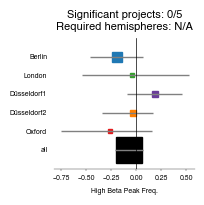

In [ ]:
forest_plot_effect_size(df_norm_conds, f'beta_high_abs_max_freq', estimator='effect_size')

/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_plot.py:696: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.set_index(group)[hemi_both_conds].reset_index()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_plot.py:696: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.set_index(group)[hemi_both_conds].reset_index()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_plot.py:696: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.set_index(group)[hemi_both_conds].reset_index()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_plot.py:696: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.set_index(group)[hemi_both_conds].reset_index()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_pl

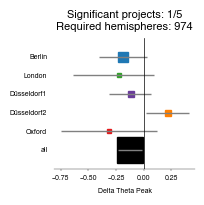

/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_plot.py:696: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.set_index(group)[hemi_both_conds].reset_index()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_plot.py:696: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.set_index(group)[hemi_both_conds].reset_index()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_plot.py:696: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.set_index(group)[hemi_both_conds].reset_index()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_plot.py:696: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.set_index(group)[hemi_both_conds].reset_index()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_pl

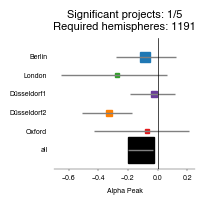

/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_plot.py:696: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.set_index(group)[hemi_both_conds].reset_index()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_plot.py:696: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.set_index(group)[hemi_both_conds].reset_index()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_plot.py:696: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.set_index(group)[hemi_both_conds].reset_index()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_plot.py:696: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.set_index(group)[hemi_both_conds].reset_index()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_pl

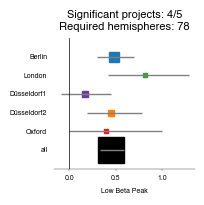

/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_plot.py:696: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.set_index(group)[hemi_both_conds].reset_index()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_plot.py:696: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.set_index(group)[hemi_both_conds].reset_index()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_plot.py:696: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.set_index(group)[hemi_both_conds].reset_index()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_plot.py:696: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.set_index(group)[hemi_both_conds].reset_index()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_pl

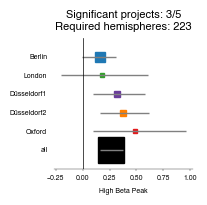

/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_plot.py:696: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.set_index(group)[hemi_both_conds].reset_index()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_plot.py:696: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.set_index(group)[hemi_both_conds].reset_index()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_plot.py:696: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.set_index(group)[hemi_both_conds].reset_index()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_plot.py:696: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.set_index(group)[hemi_both_conds].reset_index()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/utils_pl

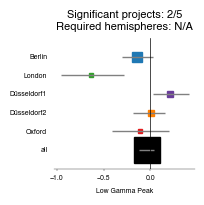

In [ ]:
for band in BANDS:
    forest_plot_effect_size(df_norm_conds, f'{band}_abs_max_log', estimator='effect_size')